Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2023/2024  
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Druga laboratorijska vježba: Linearni diskriminativni modeli i logistička regresija

*Verzija: 1.1 (ispravljena greška u tekstu prvog zadatka)  
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2023 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **5. studenog 2023. u 23:59h**

------------------------------

### Pravila predaje
Predajom vježbe potvrđujete sljedeće točke:
1. Niste od drugoga primili pomoć pri rješavanju vježbe;
2. Atribuirali ste dijelove koda koji su preuzeti s interneta referencirajući ih u komentarima;
3. Niste koristili dijelove koda s interneta koji su specifični za laboratorijsku vježbu;
4. Niste koristili UI-asistente za kodiranje kao npr. GitHub Copilot (uključivo alate generativne UI, kao što je ChatGPT).

**Povreda bilo kojeg od gornjih pravila smatra se prekršajem te povlači akademske sankcije.**

### Upute

Druga laboratorijska vježba sastoji se od šest zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [85]:
import numpy as np
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['clf', 'trace']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [86]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h != None: 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Linearna regresija kao klasifikator

U prethodnoj laboratorijskoj vježbi koristili smo model linearne regresije za, naravno, regresiju. Međutim, model linearne regresije može se koristiti i za **klasifikaciju**. Iako zvuči pomalo kontraintuitivno, zapravo je dosta jednostavno. Naime, cilj je naučiti funkciju $f(\mathbf{x})$ koja za pozitivne primjere predviđa vrijednost $1$, dok za negativne primjere predviđa vrijednost $0$. U tom slučaju, funkcija $f(\mathbf{x})=0.5$ predstavlja granicu između klasa, tj. primjeri za koje vrijedi $h(\mathbf{x})\geq 0.5$ klasificiraju se kao pozitivni, dok se ostali klasificiraju kao negativni.

Klasifikacija pomoću linearne regresije implementirana je u razredu [`RidgeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html). U sljedećim podzadatcima **istrenirajte** taj model na danim podatcima i **prikažite** dobivenu granicu između klasa. Pritom isključite regularizaciju ($\alpha = 0$, odnosno `alpha=0`). Također i ispišite **točnost** vašeg klasifikacijskog modela (smijete koristiti funkciju [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)). Skupove podataka vizualizirajte korištenjem pomoćne funkcije ``plot_clf_problem(X, y, h=None)`` koja je dana na početku ove bilježnice. `X` i `y` predstavljaju ulazne primjere i oznake, dok `h` predstavlja funkciju predikcije modela (npr. `model.predict`). 

U ovom zadatku cilj je razmotriti kako se klasifikacijski model linearne regresije ponaša na linearno odvojim i neodvojivim podatcima.

In [87]:
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.metrics import accuracy_score

### (a)

Prvo, isprobajte *ugrađeni* model na linearno odvojivom skupu podataka `seven` ($N=7$).

In [88]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

Accuracy: 100.0%


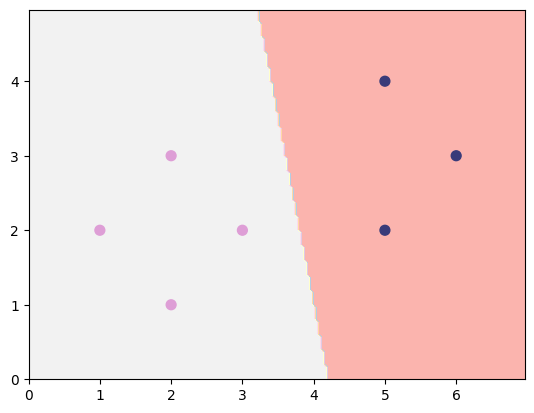

In [89]:
# Vaš kôd ovdje
clf = RidgeClassifier(alpha=0).fit(seven_X, seven_y)
seven_y_prediction = clf.predict(seven_X)
accuracy = accuracy_score(seven_y, seven_y_prediction)
print(f"Accuracy: {accuracy * 100}%")
plot_2d_clf_problem(seven_X, seven_y, lambda x : clf.predict(x))

Kako bi se uvjerili da se u isprobanoj implementaciji ne radi o ničemu doli o običnoj linearnoj regresiji, napišite kôd koji dolazi do jednakog rješenja korištenjem isključivo razreda [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Funkciju za predikciju, koju predajete kao treći argument `h` funkciji `plot_2d_clf_problem`, možete definirati lambda-izrazom: `lambda x : model.predict(x) >= 0.5`.

Accuracy: 100.0%


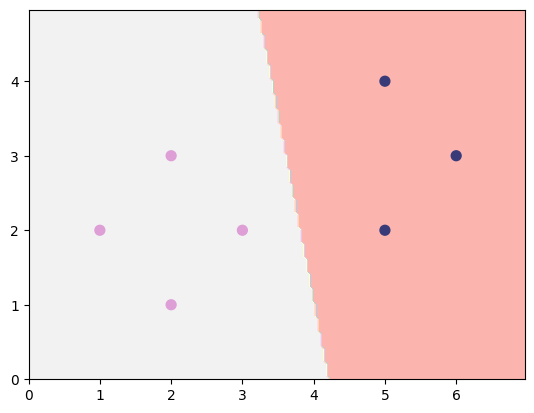

In [90]:
# Vaš kôd ovdje
clf_lr = LinearRegression().fit(seven_X, seven_y)
seven_y_prediction_lr = clf_lr.predict(seven_X)
accuracy_lr = accuracy_score(seven_y, seven_y_prediction_lr >= 0.5)
print(f"Accuracy: {accuracy_lr * 100}%")
plot_2d_clf_problem(seven_X, seven_y, lambda x : clf_lr.predict(x) >= 0.5)

**Q:** Kako bi bila definirana granica između klasa ako bismo koristili oznake klasa $-1$ i $1$ umjesto $0$ i $1$?

### (b)  

Probajte isto na linearno odvojivom skupu podataka `outlier` ($N=8$):

In [91]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

Accuracy: 100.0%


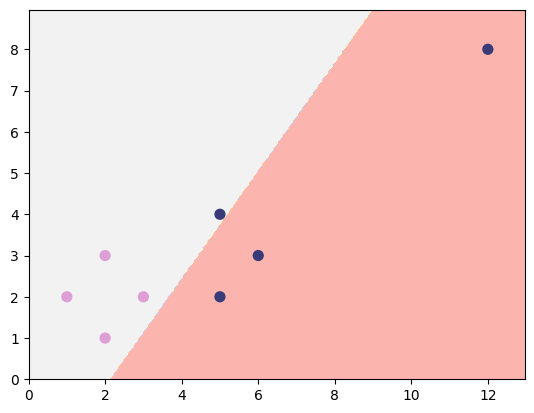

In [92]:
# Vaš kôd ovdje
clf_outlier = RidgeClassifier(alpha=0).fit(outlier_X, outlier_y)
outlier_y_predictions = clf.predict(outlier_X)
accuracy = accuracy_score(outlier_y, outlier_y_predictions)
print(f"Accuracy: {accuracy * 100}%")
plot_2d_clf_problem(outlier_X, outlier_y, lambda x : clf_outlier.predict(x))

**Q:** Zašto model ne ostvaruje potpunu točnost iako su podatci linearno odvojivi?

### (c)  

Završno, probajte isto na linearno neodvojivom skupu podataka `unsep` ($N=8$):

In [93]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

Accuracy: 87.5%


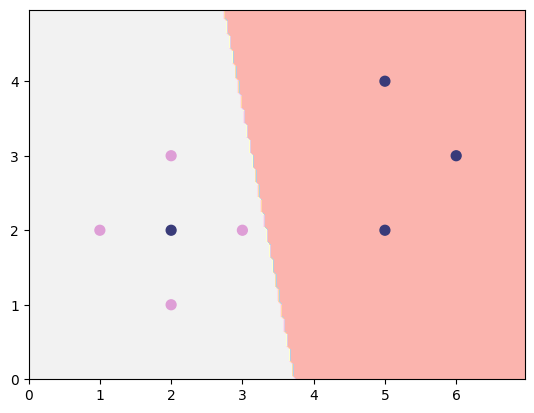

In [94]:
# Vaš kôd ovdje
clf_unsep = RidgeClassifier(alpha=0).fit(unsep_X, unsep_y)
unsep_y_predictions = clf_unsep.predict(unsep_X)
accuracy = accuracy_score(unsep_y, unsep_y_predictions)
print(f"Accuracy: {accuracy * 100}%")
plot_2d_clf_problem(unsep_X, unsep_y, lambda x : clf_unsep.predict(x))

**Q:** Očito je zašto model nije u mogućnosti postići potpunu točnost na ovom skupu podataka. Međutim, smatrate li da je problem u modelu ili u podacima? Argumentirajte svoj stav.

### 2. Višeklasna klasifikacija

Postoji više načina kako se binarni klasifikatori mogu se upotrijebiti za višeklasnu klasifikaciju. Najčešće se koristi shema tzv. **jedan-naspram-ostali** (engl. *one-vs-rest*, OVR), u kojoj se trenira po jedan klasifikator $h_j$ za svaku od $K$ klasa. Svaki klasifikator $h_j$ trenira se da razdvaja primjere klase $j$ od primjera svih drugih klasa, a primjer se klasificira u klasu $j$ za koju je $h_j(\mathbf{x})$ maksimalan.

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte slučajan dvodimenzijski skup podataka od tri klase i prikažite ga koristeći funkciju `plot_2d_clf_problem`. Radi jednostavnosti, pretpostavite da nema redundantnih značajki te da je svaka od klasa "zbijena" upravo u jednu grupu.

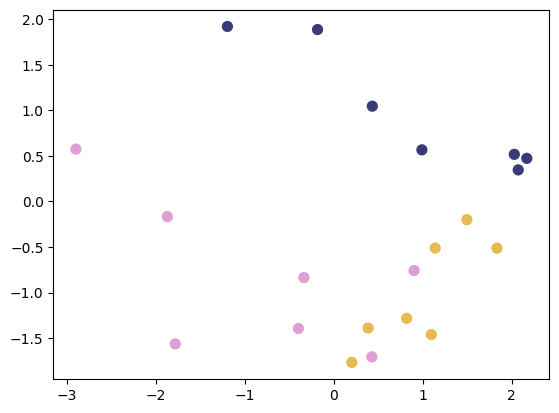

In [95]:
from sklearn.datasets import make_classification

# Vaš kôd ovdje
generated_2d_dataset = make_classification(n_samples=21, n_features=2, n_redundant=0, n_clusters_per_class=1, n_informative=2, n_classes=3)
generated_2d_dataset_X = generated_2d_dataset[0]
generated_2d_dataset_y = generated_2d_dataset[1]
plot_2d_clf_problem(generated_2d_dataset_X, generated_2d_dataset_y)

Trenirajte tri binarna klasifikatora, $h_1$, $h_2$ i $h_3$ te prikažite granice između klasa (tri grafikona). Zatim definirajte $h(\mathbf{x})=\mathrm{argmax}_j h_j(\mathbf{x})$  (napišite svoju funkciju `predict` koja to radi) i prikažite granice između klasa za taj model. Zatim se uvjerite da biste identičan rezultat dobili izravno primjenom modela `RidgeClassifier`, budući da taj model za višeklasan problem zapravo interno implementira shemu jedan-naspram-ostali.

**Q:** Alternativna shema jest ona zvana **jedan-naspram-jedan** (engl, *one-vs-one*, OVO). Koja je prednost sheme OVR nad shemom OVO? A obratno?

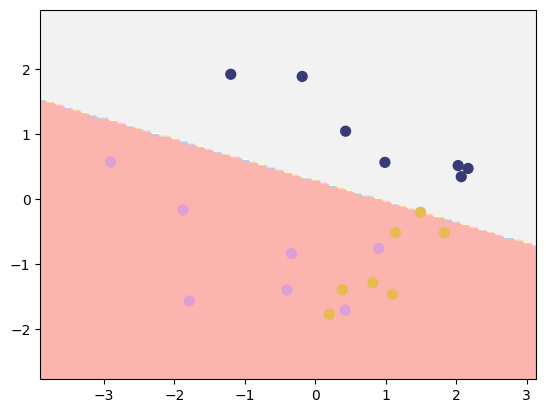

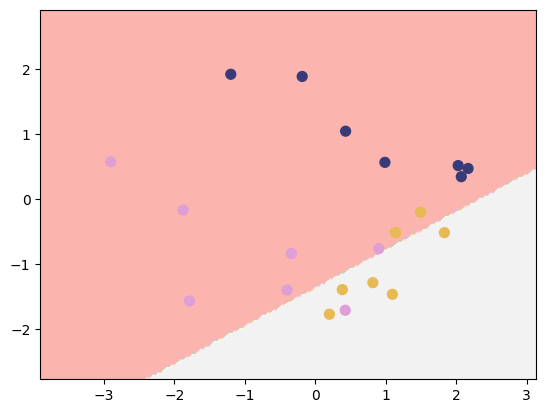

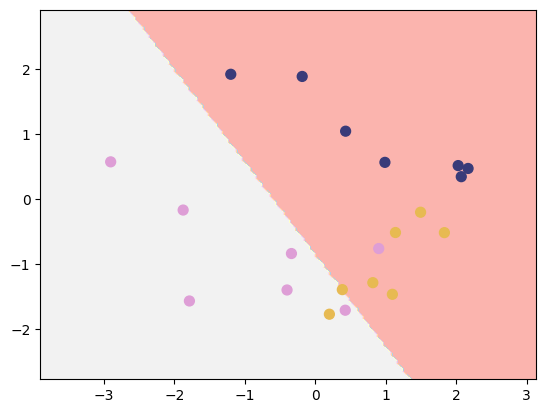

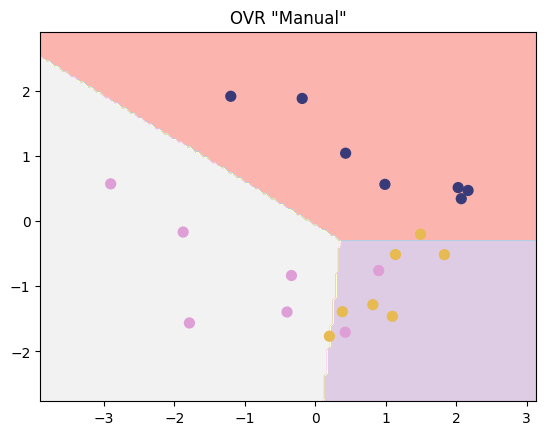

OVR "Manual" predictions:
[ 0.20233353 -1.76694637] is predicted as 1 when actual is class: 1 - correct prediction: TRUE
[-1.78451692 -1.56352508] is predicted as 2 when actual is class: 2 - correct prediction: TRUE
[ 0.90247484 -0.75784657] is predicted as 1 when actual is class: 2 - correct prediction: FALSE
[ 1.14010916 -0.51149258] is predicted as 1 when actual is class: 1 - correct prediction: TRUE
[-0.1836495   1.88685432] is predicted as 0 when actual is class: 0 - correct prediction: TRUE
[ 0.81876658 -1.28222712] is predicted as 1 when actual is class: 1 - correct prediction: TRUE
[-0.39877079 -1.39462447] is predicted as 2 when actual is class: 2 - correct prediction: TRUE
[2.03008355 0.5171701 ] is predicted as 0 when actual is class: 0 - correct prediction: TRUE
[-1.19739152  1.92036297] is predicted as 0 when actual is class: 0 - correct prediction: TRUE
[0.43266647 1.04557772] is predicted as 0 when actual is class: 0 - correct prediction: TRUE
[ 0.38576216 -1.38920184] i

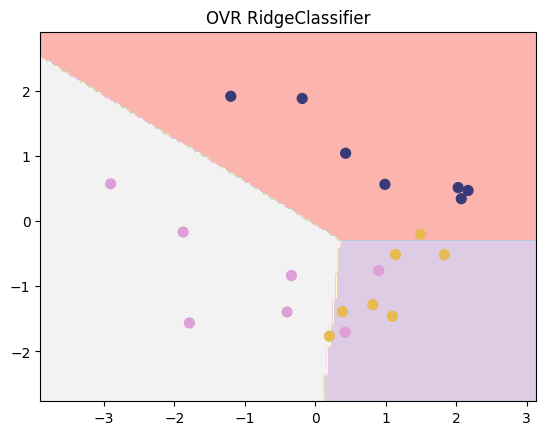

In [96]:
# Vaš kôd ovdje
def separate_classes(y, class_number):
    y_separated = np.where(y == class_number, 1, 0)
    return y_separated

def predict(x, clf1, clf2, clf3):
    return np.argmax([clf1.predict(x), clf2.predict(x), clf3.predict(x)])

separated_classes_0 = separate_classes(generated_2d_dataset_y, 0)
separated_classes_1 = separate_classes(generated_2d_dataset_y, 1)
separated_classes_2 = separate_classes(generated_2d_dataset_y, 2)

clf_0 = LinearRegression().fit(generated_2d_dataset_X, separated_classes_0)
clf_1 = LinearRegression().fit(generated_2d_dataset_X, separated_classes_1)
clf_2 = LinearRegression().fit(generated_2d_dataset_X, separated_classes_2)

plot_2d_clf_problem(generated_2d_dataset_X, generated_2d_dataset_y, lambda x : clf_0.predict(x) >= 0.5)
plt.show()
plot_2d_clf_problem(generated_2d_dataset_X, generated_2d_dataset_y, lambda x : clf_1.predict(x) >= 0.5)
plt.show()
plot_2d_clf_problem(generated_2d_dataset_X, generated_2d_dataset_y, lambda x : clf_2.predict(x) >= 0.5)
plt.show()

plot_2d_clf_problem(generated_2d_dataset_X, generated_2d_dataset_y, lambda x : predict(x.reshape(1, -1), clf_0, clf_1, clf_2))
plt.title("OVR \"Manual\"")
plt.show()

print("OVR \"Manual\" predictions:")
for i in range(len(generated_2d_dataset_X)):
    instance = generated_2d_dataset_X[i]
    predicted_class = predict(generated_2d_dataset_X[i].reshape(1, -1), clf_0, clf_1, clf_2)
    actual_class = generated_2d_dataset_y[i]
    is_correct = predicted_class == actual_class
    print(f"{instance} is predicted as {predicted_class} when actual is class: {actual_class} - correct prediction: {is_correct.__str__().upper()}")
    
print("OVR RidgeClassifier predictions:")
clf_ovr = RidgeClassifier(alpha=0).fit(generated_2d_dataset_X, generated_2d_dataset_y)
plot_2d_clf_problem(generated_2d_dataset_X, generated_2d_dataset_y, lambda x : clf_ovr.predict(x))
plt.title("OVR RidgeClassifier")
plt.show()


### 3. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

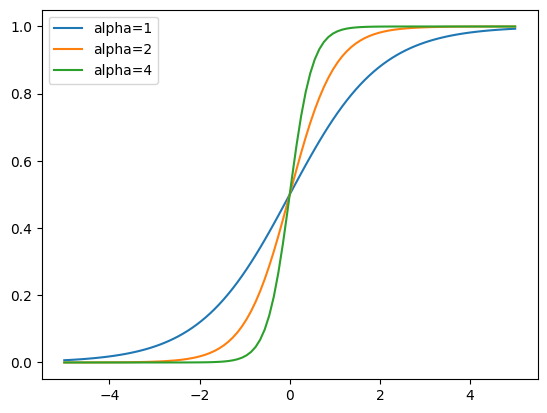

In [97]:
# Vaš kôd ovdje
sigmoid = lambda alpha, x: 1 / (1 + np.exp(-alpha * x))

alphas = [1, 2, 4]

x = np.linspace(-5, 5, 100)

for alpha in alphas:
    plt.plot(x, sigmoid(alpha, x), label=f"alpha={alpha}")
    plt.legend()

plt.show()
    

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [98]:
# from numpy import linalg
# 
# def lr_h(x, w):
#     return sigmoid(1, x @ w.T)
# 
# def cross_entropy_error(X, y, w):
#     error = 0
#     for x in range(len(X)):
#         error += y[x] * np.log(lr_h(X[x], w)) + (1 - y[x]) * np.log(1 - lr_h(X[x], w))
#     return -error / len(X)
# 
# def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
#     # Vaš kôd ovdje
#     w_tilda = np.zeros(X.shape[1] + 1)
#     print(w_tilda.shape)
#     current_iteration = 0
#     error = cross_entropy_error(X, y, w_tilda[1:])
#     
#     trace_stack = []
#     
#     while current_iteration < max_iter:
#         print("Iteration: ", current_iteration, " Error: ", error, " w_tilda: ", w_tilda)
#         delta_w = np.zeros(X.shape[1])
#         delta_w0 = 0.0
#         for i in range(0, len(X)):
#             h = lr_h(X[i], w_tilda[1:])
#             delta_w0 = delta_w0 - (h - y[i])
#             delta_w = delta_w - (h - y[i]) * X[i]
#         w_tilda[0] = delta_w0 + eta * delta_w0
#         w_tilda[1:] = w_tilda[1:] * (1 - eta * alpha) + eta * delta_w
#         current_iteration += 1
#         error_difference = error - cross_entropy_error(X, y, w_tilda[1:])
#         
#         if error_difference < epsilon:
#             print("Error difference < epsilon")
#             break
#         else:
#             error = cross_entropy_error(X, y, w_tilda[1:])
#             
#         if trace:
#             trace_stack.append(w_tilda)
#             
#     if trace:
#         return w_tilda, trace_stack
#     else:
#         return w_tilda
#     

def lr_h(x, w):
    return sigmoid(1, w @ x)

def cross_entropy_error(X, y, w):
    error = 0
    for i in range(len(X)):
        error += - (y[i] * np.log(lr_h(X[i], w))) - ((1 - y[i]) * np.log(1 - lr_h(X[i], w)))
    return error / len(X)
    
def lr_train(X, y: np.ndarray, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    # Vaš kôd ovdje
    w_tilda = np.zeros(X.shape[1] + 1)
    y = np.where(y <= 0, 0, 1)
    
    # https://note.nkmk.me/en/python-numpy-insert/
    X_dummy = np.insert(X, 0, np.ones(len(X)), axis=1)
    
    error = cross_entropy_error(X_dummy, y, w_tilda)
    current_iteration = 0
    
    trace_stack = []
    
    while current_iteration < max_iter:
        current_iteration += 1
        
        print(f"Iteration {current_iteration}, error: {error}, w_tilda: {w_tilda}")
        delta_w = np.zeros(X.shape[1])    
        delta_w0 = 0.0
        
        for i in range(0, len(X)):
            h = lr_h(X_dummy[i], w_tilda)
            delta_w0 = delta_w0 - (h - y[i])
            delta_w = delta_w - (h - y[i]) * X[i]
        
        w_tilda[0] = w_tilda[0] + eta * delta_w0
        w_tilda[1:] = w_tilda[1:] * (1 - alpha * eta) + eta * delta_w
        
        if trace is True:
            trace_stack.append(np.array(w_tilda))
            
        new_error = cross_entropy_error(X_dummy, y, w_tilda)
        # print(f"Old error: {error}")
        # print(f"New error: {new_error}")
        # print(f"Err - new err = {error - new_error}")
        if abs(error - new_error) < epsilon:
            print(f"Error change smaller than epsilon {epsilon}")
            break
        
        error = new_error
        
    return w_tilda, trace_stack

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [99]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

Iteration 1, error: 0.6931471805599453, w_tilda: [0. 0. 0.]
Iteration 2, error: 0.6728357699112891, w_tilda: [ 0.005 -0.04  -0.005]
Iteration 3, error: 0.6611220707786382, w_tilda: [ 0.01251723 -0.06914041 -0.00324794]
Iteration 4, error: 0.6527991085662536, w_tilda: [ 0.02155099 -0.09157139  0.00256538]
Iteration 5, error: 0.6458882972771026, w_tilda: [ 0.03149352 -0.10981148  0.01080817]
Iteration 6, error: 0.6396259159910483, w_tilda: [ 0.04197646 -0.12538341  0.02049355]
Iteration 7, error: 0.6337092264576507, w_tilda: [ 0.05277359 -0.13922078  0.0310167 ]
Iteration 8, error: 0.6280145715631781, w_tilda: [ 0.06374416 -0.15190481  0.04200186]
Iteration 9, error: 0.6224894285875997, w_tilda: [ 0.07479969 -0.16380191  0.05321325]
Iteration 10, error: 0.6171100401606923, w_tilda: [ 0.08588424 -0.17514544  0.06450201]
Iteration 11, error: 0.6118644512044513, w_tilda: [ 0.09696238 -0.18608517  0.07577399]
Iteration 12, error: 0.6067456178289342, w_tilda: [ 0.10801167 -0.19671793  0.08696

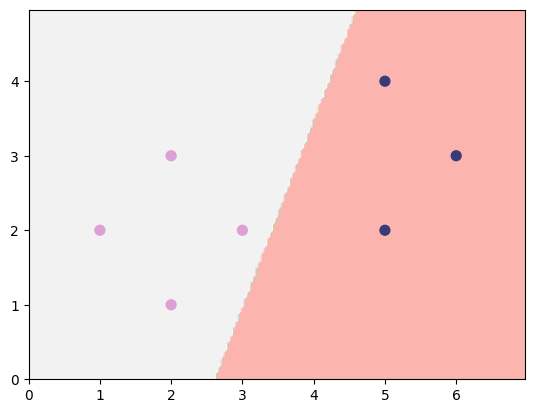

In [100]:
# Vaš kôd ovdje
weights, trace = lr_train(seven_X, seven_y, max_iter=100000)

seven_X_dummy = np.insert(seven_X, 0, np.ones(len(seven_X)), axis=1)

plot_2d_clf_problem(seven_X, seven_y, lambda x: lr_h(np.insert(x, 0, 1), weights) >= 0.5)

 **Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [101]:
from sklearn.metrics import zero_one_loss

Iteration 1, error: 0.6931471805599453, w_tilda: [0. 0. 0.]
Iteration 2, error: 0.6728357699112891, w_tilda: [ 0.005 -0.04  -0.005]
Iteration 3, error: 0.6611220707786382, w_tilda: [ 0.01251723 -0.06914041 -0.00324794]
Iteration 4, error: 0.6527991085662536, w_tilda: [ 0.02155099 -0.09157139  0.00256538]
Iteration 5, error: 0.6458882972771026, w_tilda: [ 0.03149352 -0.10981148  0.01080817]
Iteration 6, error: 0.6396259159910483, w_tilda: [ 0.04197646 -0.12538341  0.02049355]
Iteration 7, error: 0.6337092264576507, w_tilda: [ 0.05277359 -0.13922078  0.0310167 ]
Iteration 8, error: 0.6280145715631781, w_tilda: [ 0.06374416 -0.15190481  0.04200186]
Iteration 9, error: 0.6224894285875997, w_tilda: [ 0.07479969 -0.16380191  0.05321325]
Iteration 10, error: 0.6171100401606923, w_tilda: [ 0.08588424 -0.17514544  0.06450201]
Iteration 11, error: 0.6118644512044513, w_tilda: [ 0.09696238 -0.18608517  0.07577399]
Iteration 12, error: 0.6067456178289342, w_tilda: [ 0.10801167 -0.19671793  0.08696

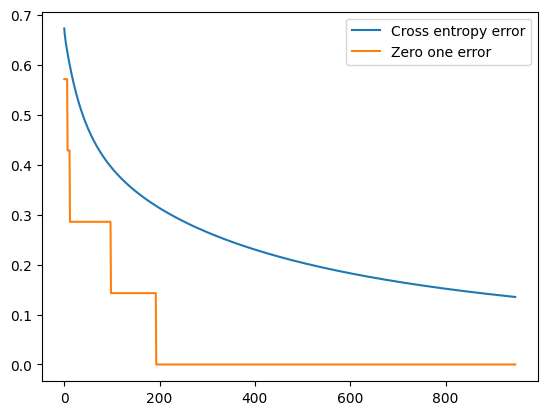

Iteration 1, error: 0.6931471805599453, w_tilda: [0. 0. 0.]
Iteration 2, error: 0.6821776048116837, w_tilda: [ 0.0025 -0.02   -0.0025]
Iteration 3, error: 0.67388760159403, w_tilda: [ 0.00563076 -0.03727754 -0.00330769]
Iteration 4, error: 0.667364448516043, w_tilda: [ 0.00926719 -0.05235097 -0.00275939]
Iteration 5, error: 0.6620108791046341, w_tilda: [ 0.01330783 -0.06564152 -0.00112798]
Iteration 6, error: 0.6574375123787801, w_tilda: [ 0.0176711  -0.07748797  0.00136727]
Iteration 7, error: 0.6533903330150156, w_tilda: [ 0.02229161 -0.08816165  0.00455074]
Iteration 8, error: 0.6497031367887162, w_tilda: [ 0.02711694 -0.09787983  0.00828181]
Iteration 9, error: 0.6462667212267481, w_tilda: [ 0.03210504 -0.1068167   0.01244776]
Iteration 10, error: 0.6430089966691597, w_tilda: [ 0.03722207 -0.11511225  0.01695796]
Iteration 11, error: 0.6398821344974849, w_tilda: [ 0.04244073 -0.12287931  0.02173944]
Iteration 12, error: 0.6368542350499942, w_tilda: [ 0.04773898 -0.13020907  0.02673

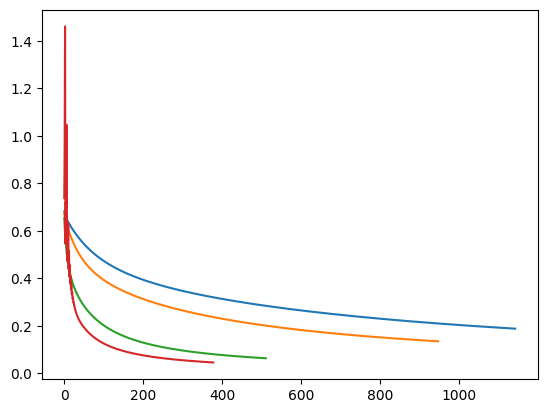

In [102]:
# Vaš kôd ovdje
# w, trace_arr = lr_train(seven_X, seven_y, max_iter=100000, trace=True)
# 
# cross_entropy_errors = []
# zero_one_errors = []
# 
# seven_X_ones = np.insert(seven_X, 0, np.ones(len(seven_X)), axis=1)
# 
# for w in trace_arr:
#     print(w)
#     cross_entropy_errors.append(cross_entropy_error(seven_X_ones, seven_y, w))
#     outputs = np.array([lr_h(x, w) for x in seven_X_ones])
#     predictions = np.where(outputs >= 0.5, 1, 0)
#     zero_one_errors.append(zero_one_loss(seven_y, predictions))

def train_logistic_regression(X, y, max_iteration, trace, eta=0.01):
    w, trace_arr = lr_train(X, y, max_iter=100000, trace=True, eta=eta)

    cross_entropy_errors = []
    zero_one_errors = []
    
    X_ones = np.insert(seven_X, 0, np.ones(len(seven_X)), axis=1)
    
    for w in trace_arr:
        cross_entropy_errors.append(cross_entropy_error(X_ones, y, w))
        outputs = np.array([lr_h(x, w) for x in X_ones])
        predictions = np.where(outputs >= 0.5, 1, 0)
        zero_one_errors.append(zero_one_loss(y, predictions))
        
    return cross_entropy_errors, zero_one_errors

cross_entr_err, zero_one_err = train_logistic_regression(seven_X, seven_y, max_iteration=10000, trace=True)
    
plt.plot(cross_entr_err, label="Cross entropy error")
plt.plot(zero_one_err, label="Zero one error")
plt.legend()
plt.show()

etas = [0.005, 0.01, 0.05, 0.1]

cross_entropy_error_by_eta = []

for eta in etas:
    ce_err, zo_err = train_logistic_regression(seven_X, seven_y, max_iteration=10000, trace=True, eta=eta)
    cross_entropy_error_by_eta.append((ce_err, eta))
    
for err, eta in cross_entropy_error_by_eta:
    plt.plot(err, label = f"Eta: {eta}")
    
plt.show()
    
    


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

Intercept: [46.26968486], coefs: [[-14.80304235   4.33454163]]


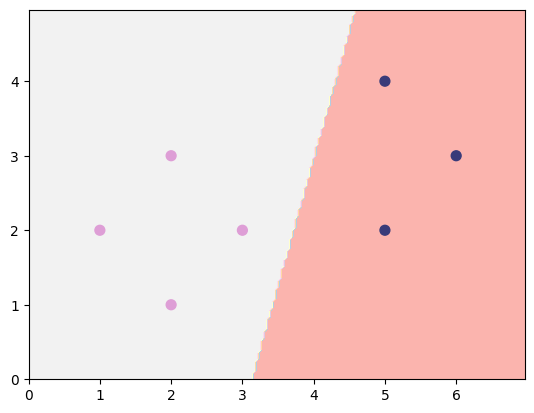

In [103]:
from sklearn.linear_model import LogisticRegression

# Vaš kôd ovdje
clf = LogisticRegression(penalty=None).fit(seven_X, seven_y)
clf.predict(seven_X)

print(f"Intercept: {clf.intercept_}, coefs: {clf.coef_}")

plot_2d_clf_problem(seven_X, seven_y, lambda x: clf.predict(x))


### 4. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [104]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

Intercept: [42.32235916], coefs: [[-12.87743574   3.00708643]]


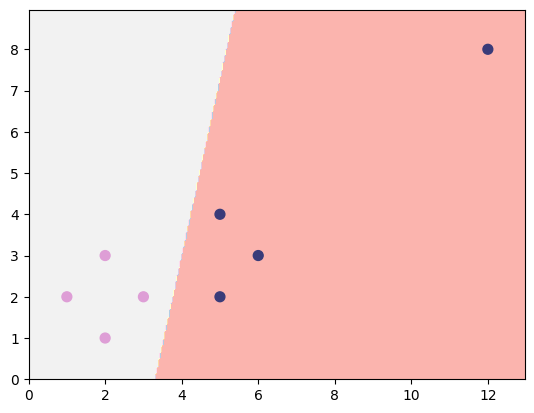

In [105]:
# Vaš kôd ovdje

clf = LogisticRegression(penalty=None).fit(outlier_X, outlier_y)

print(f"Intercept: {clf.intercept_}, coefs: {clf.coef_}")

plot_2d_clf_problem(outlier_X, outlier_y, lambda x: clf.predict(x))

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

Iteration 1, error: 0.6931471805599453, w_tilda: [0. 0. 0.]
Iteration 2, error: 0.6728357699112891, w_tilda: [ 0.005 -0.04  -0.005]
Iteration 3, error: 0.6611220707786382, w_tilda: [ 0.01251723 -0.06914041 -0.00324794]
Iteration 4, error: 0.6527991085662536, w_tilda: [ 0.02155099 -0.09157139  0.00256538]
Iteration 5, error: 0.6458882972771026, w_tilda: [ 0.03149352 -0.10981148  0.01080817]
Iteration 6, error: 0.6396259159910483, w_tilda: [ 0.04197646 -0.12538341  0.02049355]
Iteration 7, error: 0.6337092264576507, w_tilda: [ 0.05277359 -0.13922078  0.0310167 ]
Iteration 8, error: 0.6280145715631781, w_tilda: [ 0.06374416 -0.15190481  0.04200186]
Iteration 9, error: 0.6224894285875997, w_tilda: [ 0.07479969 -0.16380191  0.05321325]
Iteration 10, error: 0.6171100401606923, w_tilda: [ 0.08588424 -0.17514544  0.06450201]
Iteration 11, error: 0.6118644512044513, w_tilda: [ 0.09696238 -0.18608517  0.07577399]
Iteration 12, error: 0.6067456178289342, w_tilda: [ 0.10801167 -0.19671793  0.08696

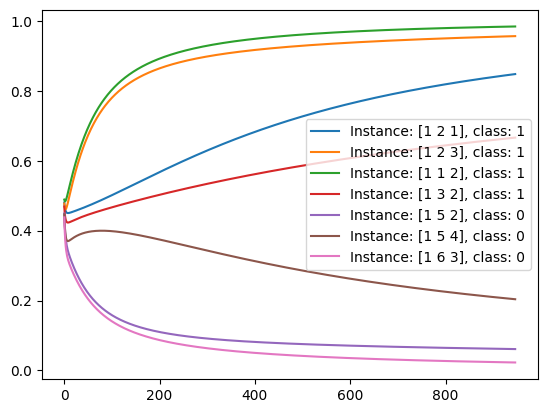

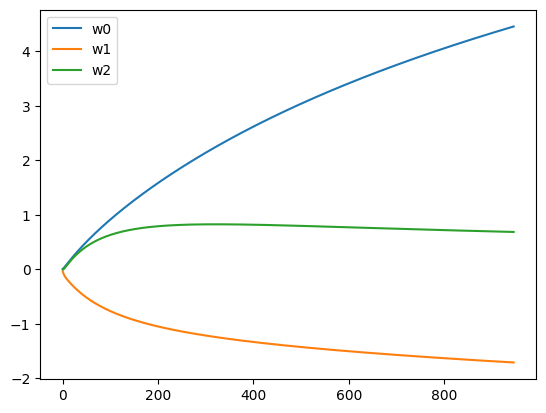

In [106]:
# Vaš kôd ovdje
weights, trace = lr_train(seven_X, seven_y, max_iter=10000, trace=True)

seven_X_dummy = np.insert(seven_X, 0, np.ones(len(seven_X)), axis=1)

for x, y in zip(seven_X_dummy, seven_y):
    plt.plot(range(len(trace)), [lr_h(x, w) for w in trace], label=f"Instance: {x}, class: {y}")

plt.legend(loc='best')
plt.show()

for i in range(len(weights)):
    plt.plot(range(len(trace)), [w[i] for w in trace], label=f"w{i}")
    
plt.legend(loc='best')
plt.show()


### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [107]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

Iteration 1, error: 0.6931471805599453, w_tilda: [0. 0. 0.]
Iteration 2, error: 0.6650560760386899, w_tilda: [ 0.    -0.05  -0.015]
Iteration 3, error: 0.6522170969256517, w_tilda: [ 0.00394064 -0.08406071 -0.0196523 ]
Iteration 4, error: 0.6448880254956988, w_tilda: [ 0.01016932 -0.10873735 -0.01830905]
Iteration 5, error: 0.6396577525746991, w_tilda: [ 0.01773527 -0.12778792 -0.01346732]
Iteration 6, error: 0.6352935885618322, w_tilda: [ 0.02608974 -0.14336699 -0.00656244]
Iteration 7, error: 0.631329991797171, w_tilda: [ 0.03490733 -0.15674514  0.00155747]
Iteration 8, error: 0.6275840899162788, w_tilda: [ 0.04399021 -0.16869241  0.01037815]
Iteration 9, error: 0.6239813308148255, w_tilda: [ 0.05321591 -0.1796855   0.01958182]
Iteration 10, error: 0.6204899094880822, w_tilda: [ 0.06250767 -0.19002414  0.02896962]
Iteration 11, error: 0.6170952583155085, w_tilda: [ 0.07181707 -0.19989899  0.03841622]
Iteration 12, error: 0.613789879965975, w_tilda: [ 0.08111345 -0.20943243  0.0478424

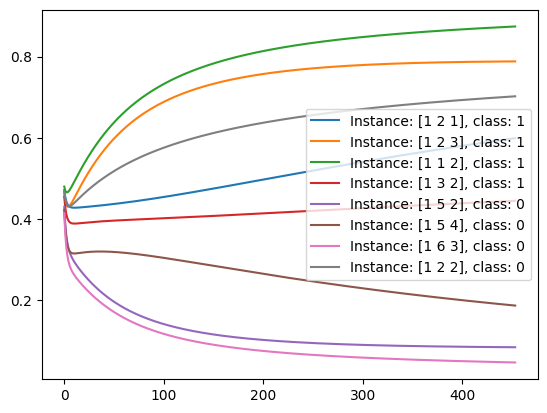

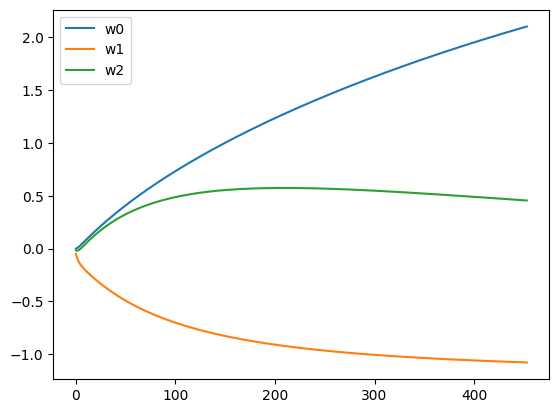

In [108]:
# Vaš kôd ovdje
weights, trace = lr_train(unsep_X, unsep_y, max_iter=10000, trace=True)

unsep_X_dummy = np.insert(unsep_X, 0, np.ones(len(unsep_X)), axis=1)

for x, y in zip(unsep_X_dummy, unsep_y):
    plt.plot(range(len(trace)), [lr_h(x, w) for w in trace], label=f"Instance: {x}, class: {y}")
    

plt.legend(loc='best')
plt.show()

for i in range(len(weights)):
    plt.plot(range(len(trace)), [w[i] for w in trace], label=f"w{i}")
    
plt.legend(loc='best')
plt.show()

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 5. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

Iteration 1, error: 0.6931471805599453, w_tilda: [0. 0. 0.]
Iteration 2, error: 0.6728357699112891, w_tilda: [ 0.005 -0.04  -0.005]
Iteration 3, error: 0.6611220707786382, w_tilda: [ 0.01251723 -0.06914041 -0.00324794]
Iteration 4, error: 0.6527991085662536, w_tilda: [ 0.02155099 -0.09157139  0.00256538]
Iteration 5, error: 0.6458882972771026, w_tilda: [ 0.03149352 -0.10981148  0.01080817]
Iteration 6, error: 0.6396259159910483, w_tilda: [ 0.04197646 -0.12538341  0.02049355]
Iteration 7, error: 0.6337092264576507, w_tilda: [ 0.05277359 -0.13922078  0.0310167 ]
Iteration 8, error: 0.6280145715631781, w_tilda: [ 0.06374416 -0.15190481  0.04200186]
Iteration 9, error: 0.6224894285875997, w_tilda: [ 0.07479969 -0.16380191  0.05321325]
Iteration 10, error: 0.6171100401606923, w_tilda: [ 0.08588424 -0.17514544  0.06450201]
Iteration 11, error: 0.6118644512044513, w_tilda: [ 0.09696238 -0.18608517  0.07577399]
Iteration 12, error: 0.6067456178289342, w_tilda: [ 0.10801167 -0.19671793  0.08696

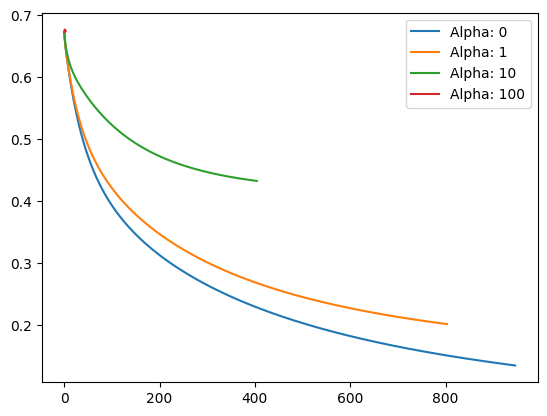

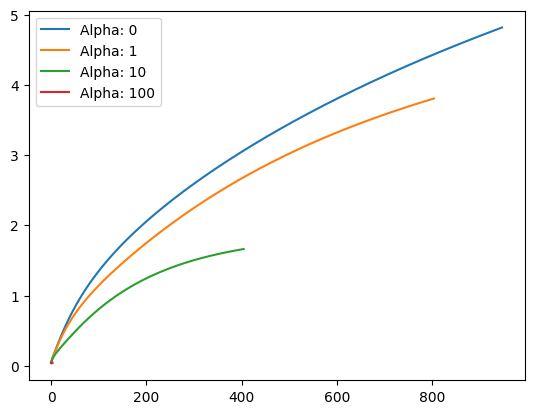

In [109]:
from numpy.linalg import norm
reg_weights = []
reg_trace = []
alphas = [0, 1, 10, 100]
for alpha in alphas:
    weights, trace = lr_train(seven_X, seven_y, max_iter=10000, trace=True, alpha=alpha)
    reg_weights.append(weights)
    reg_trace.append(trace)
    
seven_X_dummy = np.insert(seven_X, 0, np.ones(len(seven_X)), axis=1)
    
for trace, alpha in zip(reg_trace, alphas):
    plt.plot(range(len(trace)), [cross_entropy_error(seven_X_dummy, seven_y, w) for w in trace], label=f"Alpha: {alpha}")
    
plt.legend(loc='best')
plt.show()

for trace, alpha in zip(reg_trace, alphas):
    plt.plot(range(len(trace)), [norm(w) for w in trace], label=f"Alpha: {alpha}")
    
plt.legend(loc='best')
plt.show()

In [110]:
# Vaš kôd ovdje

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 6. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

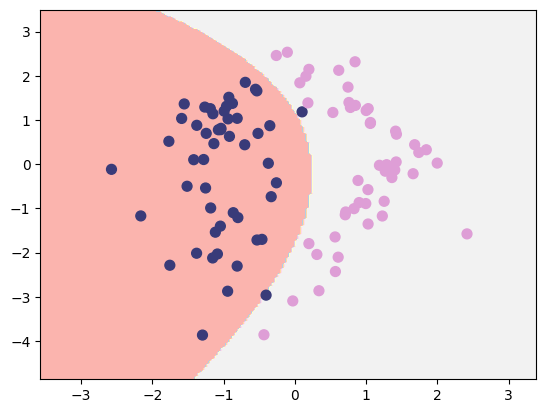

In [113]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

X, y = make_classification(n_classes=2, n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, n_informative=2)

poly_2 = PolynomialFeatures(2)
clf_2 = LogisticRegression().fit(poly_2.fit_transform(X), y)
plot_2d_clf_problem(X, y, lambda x : clf_2.predict(poly_2.transform(x)))


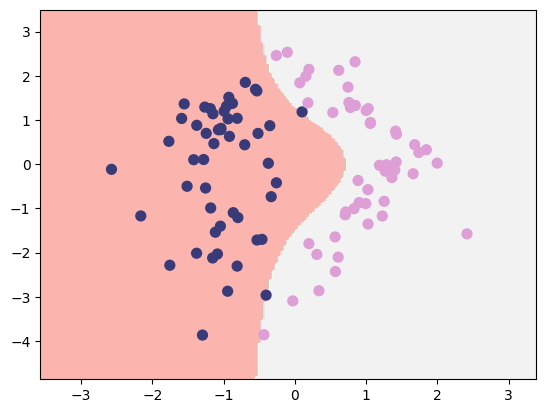

In [114]:
# Vaš kôd ovdje
poly_3 = PolynomialFeatures(3)
clf_3 = LogisticRegression().fit(poly_3.fit_transform(X), y)
plot_2d_clf_problem(X, y, lambda x : clf_3.predict(poly_3.transform(x)))

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?